In [1]:
#Load and preprocess
import os
import cv2
import numpy as np
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout


def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".png"):
            img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
    return images

In [2]:
#Load the images and preprocess them (resize, flatten, and normalize)
folder_path_class1 = r'C:\Users\786me\Desktop\FinalYearProject\ASDScanPath\Dataset\Orignal\Control'
folder_path_class2 = r'C:\Users\786me\Desktop\FinalYearProject\ASDScanPath\Dataset\Orignal\Patient'

# Load images from each class folder
images_class1 = load_images_from_folder(folder_path_class1)
images_class2 = load_images_from_folder(folder_path_class2)

# Assign labels to images (0 for class1, 1 for class2)
labels_class1 = [0] * len(images_class1)
labels_class2 = [1] * len(images_class2)

# Resize the images to a consistent size (e.g., 64x64)
resize_dim = (224, 224)
resized_images_class1 = [cv2.resize(img, resize_dim) for img in images_class1]
resized_images_class2 = [cv2.resize(img, resize_dim) for img in images_class2]

# Flatten and normalize the images into 1D arrays
flattened_images_class1 = [img.flatten() / 255.0 for img in resized_images_class1]
flattened_images_class2 = [img.flatten() / 255.0 for img in resized_images_class2]

# Combine the image data and labels
X = np.vstack((flattened_images_class1, flattened_images_class2))
y = np.hstack((labels_class1, labels_class2))

In [3]:
def optimal_n_components(data, explained_variance_threshold):
    pca = PCA()
    pca.fit(data)
    cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
    
    optimal_n = np.where(cumulative_explained_variance >= explained_variance_threshold)[0][0] + 1
    
    return optimal_n

explained_variance_threshold = 0.97
n_components = optimal_n_components(X, explained_variance_threshold)

print(f'Optimal number of components for {explained_variance_threshold*100}% explained variance: {n_components}')

Optimal number of components for 97.0% explained variance: 447


In [4]:
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

In [5]:
# Create a simple ANN model
def create_ann_model(input_dim):
    model = Sequential()
    model.add(Dense(500, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.1))
    
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Define the input dimension based on the number of PCA components
input_dim = X_pca.shape[1]

# Create the ANN model
ann_model = create_ann_model(input_dim)

# Compile the model
ann_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
ann_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               224000    
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 16)                8016      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 232,033
Trainable params: 232,033
Non-trainable params: 0
_________________________________________________________________


In [6]:
#split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [7]:
# Train the model
history = ann_model.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.2)


Epoch 1/30
22/22 [==============================] - 1s 14ms/step - loss: 0.6980 - accuracy: 0.5759 - val_loss: 0.6906 - val_accuracy: 0.5795
Epoch 2/30
22/22 [==============================] - 0s 5ms/step - loss: 0.6864 - accuracy: 0.6074 - val_loss: 0.6876 - val_accuracy: 0.5795
Epoch 3/30
22/22 [==============================] - 0s 5ms/step - loss: 0.6801 - accuracy: 0.6160 - val_loss: 0.6848 - val_accuracy: 0.5909
Epoch 4/30
22/22 [==============================] - 0s 5ms/step - loss: 0.6673 - accuracy: 0.6590 - val_loss: 0.6817 - val_accuracy: 0.6136
Epoch 5/30
22/22 [==============================] - 0s 5ms/step - loss: 0.6592 - accuracy: 0.6934 - val_loss: 0.6782 - val_accuracy: 0.6136
Epoch 6/30
22/22 [==============================] - 0s 5ms/step - loss: 0.6457 - accuracy: 0.7106 - val_loss: 0.6744 - val_accuracy: 0.6250
Epoch 7/30
22/22 [==============================] - 0s 5ms/step - loss: 0.6416 - accuracy: 0.7192 - val_loss: 0.6704 - val_accuracy: 0.6477
Epoch 8/30
22/22 [=

4/4 [==============================] - 0s 2ms/step


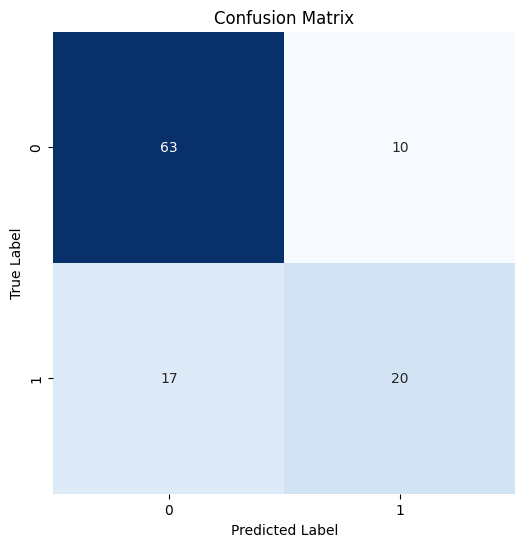

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Make predictions on the test data
y_pred_proba = ann_model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [9]:
# Extract the values from the confusion matrix
TN, FP, FN, TP = cm.ravel()

# Calculate Sensitivity (Recall)
sensitivity = TP / (TP + FN)

# Calculate Precision
precision = TP / (TP + FP)

# Calculate PPV (same as Precision)
ppv = precision

# Calculate NPV
npv = TN / (TN + FN)

print(f"Sensitivity (Recall): {sensitivity:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Positive Predictive Value (PPV): {ppv:.2f}")
print(f"Negative Predictive Value (NPV): {npv:.2f}")


Sensitivity (Recall): 0.54
Precision: 0.67
Positive Predictive Value (PPV): 0.67
Negative Predictive Value (NPV): 0.79


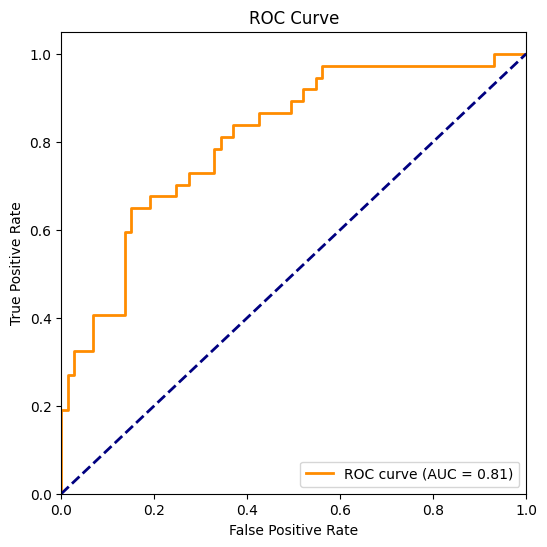

In [10]:
from sklearn.metrics import roc_curve, auc

# Calculate the false positive rate (FPR), true positive rate (TPR), and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
